In [3]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [4]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A point
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    x_length_squared = x[0] ** 2 + x[1] ** 2
    return a * np.exp(-gamma * x_length_squared) - np.exp(-beta * x_length_squared)


In [50]:
class GCN2D(object):
    
    def __init__(self,
                 numX,
                 numY,
                 inhibitionWindow,
                 inhibitionRadius,                 
                 inhibitionStrength,
                 boostEffect=10,
                 boostDecay=0.2,
                 dt=0.001,
                 numPlaces=200,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                ):
        self.activity = torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow, 1+2*inhibitionWindow], dtype=torch.float,
                                 device=device)
        self.numX = numX
        self.numY = numY
        
        for i in range(1+2*inhibitionWindow):
            for j in range(1+2*inhibitionWindow):
                xComp = np.abs(i - (inhibitionWindow))
                yComp = np.abs(j - (inhibitionWindow))
                dist = np.asarray((xComp, yComp))
                
                self.filter[0, 0, i, j] = w_0(dist/inhibitionRadius)*inhibitionStrength
                
        self.activationHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.boostEffect = boostEffect
        self.boostDecay = boostDecay
        self.dt = dt
        self.globalTonic = torch.tensor([globalTonic], device=device, dtype=torch.float)
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.random.rand(numPlaces, 2), device=device, dtype=torch.float)
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numY, numPlaces), device=device, dtype=torch.float)
        self.placeWeights /= 10.
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """
        envelopeX = [1 if np.abs(p) < 1 - self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((np.abs(p) - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.linspace(-1, 1, self.numX)]

        envelopeY = [1 if np.abs(p) < 1 - self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((np.abs(p) - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.linspace(-1, 1, self.numY)]

        return np.outer(envelopeX, envelopeY)
    
    def randomLesions(self, numLesions, lesionRadius):
        lesions = []
        for i in range(numLesions):
            x = int(np.random.rand()*self.numX)
            y = int(np.random.rand()*self.numX)
            lesions.append((x, y))
            
        radii = [lesionRadius] * numLesions
        
        self.addLesions(lesions, radii)
    
    def addLesions(self, lesionCenters, lesionRadii):
        for center, radius in zip(lesionCenters, lesionRadii):
            for x in range(self.numX):
                for y in range(self.numY):
                    if (x - center[0])**2 + (y - center[1])**2 < radius**2:
                        self.envelope[x, y] = 0.


        
    def step(self):        
        self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX, self.numY)
        self.instantaneous += conv2d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous += self.boostEffect * self.activationHistory
        self.instantaneous *= self.envelope
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        self.activationHistory += (torch.sum(self.activity)/torch.sum(self.envelope) - self.activity)*self.envelope
        self.activationHistory *= 1 - self.boostDecay
        
        
    def simulate(self, time,logFreq = 10.):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY), device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(numSteps/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)
        
        for t in range(numSteps):
            self.step()
            if t % logFreq == 0:
                s = int(t/logFreq)
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX, self.numY))
                
        return output.cpu().numpy()
    
    def learn(self, time):  
        self.activityBuffer = torch.zeros([self.stdpWindow, 1, self.numX, self.numY],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)
        self.bufferIndex = 0
        
        times = np.arange(0, time, self.dt)
        trajectory = np.zeros((len(times), 2))
        trajectory[:, 0] = (np.sin(dir * (times * np.pi / -np.pi / 2.)) + 1)/2
        trajectory[:, 1] = (np.sin(dir * (times * np.pi / -np.pi / 2.)) + 1)/2
        
        velocities = np.diff(trajectory)
        
        for i, t in enumerate(times):
            pos = trajectory[i, :]
            v = velocities[i]
            
            
            
        
    def stdpUpdate(self, time, clearBuffer=False):
        if self.bufferIndex < self.stdpBuffer.shape[0]:
            self.stdpBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.sdtpWindow):
                i = t + self.bufferIndex % self.stdpWindow            
                self.placeWeights += torch.ger(self.placeBuffer[i],
                                               self.activity.view(self.numX*self.numY))* \
                                        self.stdpValues[t]
                self.placeWeights -= torch.ger(self.placeActivity, self.activityBuffer[i]) *\
                                        self.stdpValues[t]
                
            self.bufferIndex += 1
            self.stdpBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            
            
        if clearBuffer:
            pass

<IPython.core.display.Javascript object>


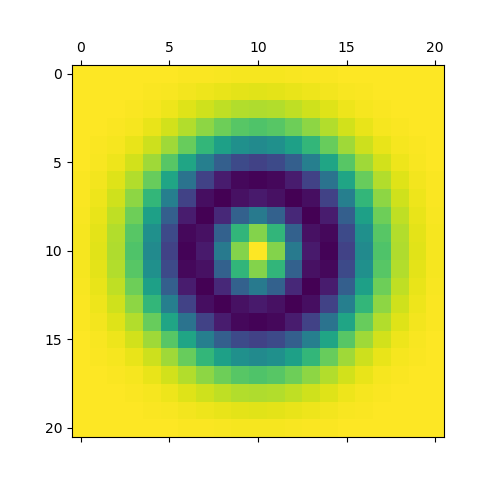

In [51]:
GCN = GCN2D(256, 256, 10, .5, 1000, globalTonic=50, dt=0.01, boostEffect=10, boostDecay=.01)
plt.matshow(GCN.filter[0,0])
plt.show()

In [52]:
GCN.randomLesions(10, 10)

At 0.0
At 0.1
At 0.2
At 0.3
At 0.4
At 0.5
At 0.6
At 0.7000000000000001
At 0.8
At 0.9
At 1.0
At 1.1
At 1.2
At 1.3
At 1.4000000000000001
At 1.5
At 1.6
At 1.7
At 1.8
At 1.9000000000000001
At 2.0
At 2.1
At 2.2
At 2.3000000000000003
At 2.4
At 2.5
At 2.6
At 2.7
At 2.8000000000000003
At 2.9
At 3.0
At 3.1
At 3.2
At 3.3000000000000003
At 3.4
At 3.5
At 3.6
At 3.7
At 3.8000000000000003
At 3.9
At 4.0
At 4.1
At 4.2
At 4.3
At 4.4
At 4.5
At 4.6000000000000005
At 4.7
At 4.8
At 4.9
At 5.0
At 5.1000000000000005
At 5.2
At 5.3
At 5.4
At 5.5
At 5.6000000000000005
At 5.7
At 5.8
At 5.9
At 6.0
At 6.1000000000000005
At 6.2
At 6.3
At 6.4
At 6.5
At 6.6000000000000005
At 6.7
At 6.8
At 6.9
At 7.0
At 7.1000000000000005
At 7.2
At 7.3
At 7.4
At 7.5
At 7.6000000000000005
At 7.7
At 7.8
At 7.9
At 8.0
At 8.1
At 8.2
At 8.3
At 8.4
At 8.5
At 8.6
At 8.700000000000001
At 8.8
At 8.9
At 9.0
At 9.1
At 9.200000000000001
At 9.3
At 9.4
At 9.5
At 9.6
At 9.700000000000001
At 9.8
At 9.9


<IPython.core.display.Javascript object>


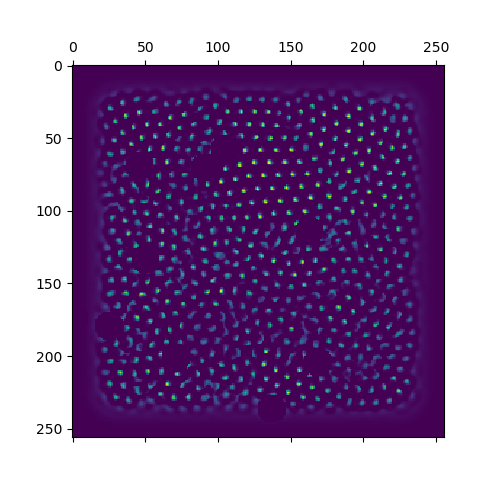

In [53]:
results = GCN.simulate(10, logFreq=10)
plt.matshow(results[-1])
plt.show()

In [15]:
def createMovie(data, name):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,

    fig = plt.figure()

    l = plt.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, len(data), fargs=(data, l),
                                  interval=10, blit=True)


    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


<IPython.core.display.Javascript object>


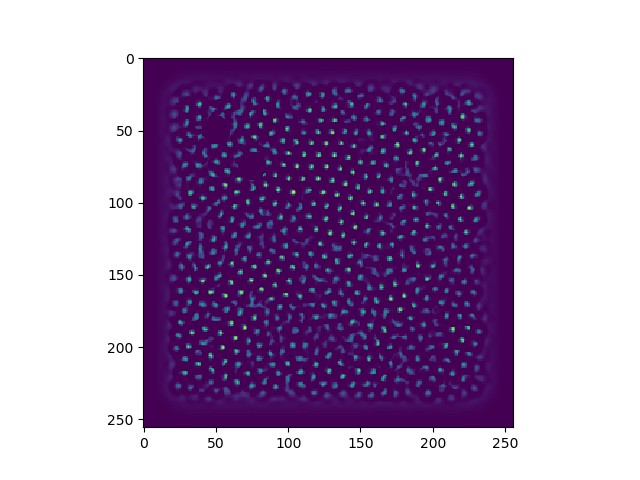

In [45]:
createMovie(results, "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4")

<video controls src="./test.mp4" />